# CORNETO KPNN compression only

This notebook runs a subset of the full notebook without training the NN, related to the PKN compression with CORNETO, and not training the NNs.


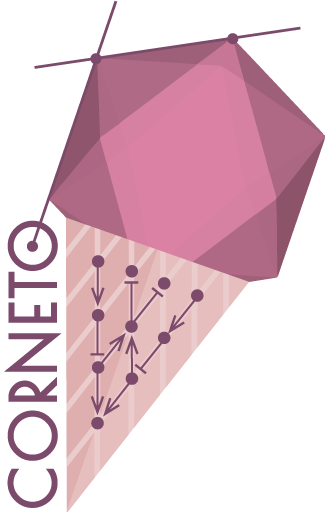

In [1]:
import os
import urllib.request
import urllib.parse
import tempfile
import pandas as pd
import scanpy as sc
import numpy as np
import corneto as cn

cn.info()

In [2]:
with urllib.request.urlopen("http://kpnn.computational-epigenetics.org/") as response:
    web_input = response.geturl()
print("Effective URL:", web_input)

files = ["TCR_Edgelist.csv", "TCR_ClassLabels.csv", "TCR_Data.h5"]

temp_dir = tempfile.mkdtemp()

# Download files
file_paths = []
for file in files:
    url = urllib.parse.urljoin(web_input, file)
    output_path = os.path.join(temp_dir, file)
    print(f"Downloading {url} to {output_path}")
    try:
        with urllib.request.urlopen(url) as response:
            with open(output_path, 'wb') as f:
                f.write(response.read())
        file_paths.append(output_path)
    except Exception as e:
        print(f"Failed to download {url}: {e}")

print("Downloaded files:")
for path in file_paths:
    print(path)

Effective URL: https://medical-epigenomics.org/papers/fortelny2019/
Downloaded files:
/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmpvhtd4s3m/TCR_Edgelist.csv
/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmpvhtd4s3m/TCR_ClassLabels.csv
/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmpvhtd4s3m/TCR_Data.h5


In [3]:
# The data contains also the original network they built with shortest paths.
# We will use it to replicate the study
df_edges = pd.read_csv(file_paths[0])
df_labels = pd.read_csv(file_paths[1])
# Import the 10x data with Scanpy
adata = sc.read_10x_h5(file_paths[2])

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
barcodes = adata.obs_names
gene_names = adata.var.index
matched_barcodes = sorted(set(barcodes.tolist()) & set(df_labels.barcode.tolist()))

In [5]:
outputs_pkn = list(set(df_edges.parent.tolist()) - set(df_edges.child.tolist()))
inputs_pkn = set(df_edges.child.tolist()) - set(df_edges.parent.tolist())
input_pkn_genes = list(set(g.split("_")[0] for g in inputs_pkn))
len(inputs_pkn), len(outputs_pkn)

(13121, 1)

In [6]:
tuples = [(r.child, 1, r.parent) for _, r in df_edges.iterrows()]
G = cn.Graph.from_sif_tuples(tuples)
G = G.prune(inputs_pkn, outputs_pkn)

# Size of the original PKN provided by the authors
G.shape

(13439, 27579)

In [7]:
# We can prefilter on top N genes to make this faster
top_n = None

# From the given PKN
outputs_pkn = list(set(df_edges.parent.tolist()) - set(df_edges.child.tolist()))
inputs_pkn = set(df_edges.child.tolist()) - set(df_edges.parent.tolist())
input_pkn_genes = list(set(g.split("_")[0] for g in inputs_pkn))

if top_n is not None and top_n > 0:
    input_pkn_genes = list(set(input_pkn_genes).intersection(df_expr.var(axis=0).sort_values(ascending=False).head(top_n).index))
    inputs_pkn = list(g + "_gene" for g in input_pkn_genes)

len(inputs_pkn), len(outputs_pkn)

(13121, 1)

In [10]:
adata_matched = adata[adata.obs_names.isin(matched_barcodes), adata.var_names.isin(input_pkn_genes)]
non_zero_genes = set(adata_matched.to_df().columns[adata_matched.to_df().sum(axis=0) >= 1e-6].values)
adata_matched = adata_matched[:, adata_matched.var_names.isin(non_zero_genes)]
adata_matched = adata_matched[:, adata_matched.to_df().sum(axis=0) != 0]
df_expr = adata_matched.to_df()
df_expr = df_expr.groupby(df_expr.columns, axis=1).max()

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_4194/2380157457.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_expr = df_expr.groupby(df_expr.columns, axis=1).max()


In [11]:
input_nn_genes = list(set(input_pkn_genes).intersection(df_expr.columns))
input_nn = [g + "_gene" for g in input_nn_genes]
len(input_nn)

12459

In [12]:
G_dag = G.copy()
new_edges = []
for g in input_nn:
    new_edges.append(G_dag.add_edge((), g))
new_edges.append(G_dag.add_edge("TCR", ()))
print(G_dag.shape)

# Find small DAG. We use Acyclic Flow to find over the space of DAGs
P = cn.opt.AcyclicFlow(G_dag)
# We enforce that the input genes and the output gene are part of the solution
P += P.expr.with_flow[new_edges] == 1
# Minimize the number of active edges
P.add_objectives(sum(P.expr.with_flow), weights=1)
P.solve(solver="SCIP", verbosity=1, max_seconds=300);

(13439, 40039)
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 13 01:44:10 PM: Your problem has 133556 variables, 348169 constraints, and 0 parameters.


/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


(CVXPY) Jan 13 01:44:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 13 01:44:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 13 01:44:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 13 01:44:11 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 13 01:44:11 PM: Compiling problem (target solver=SCIP).
(CVXPY) Jan 13 01:44:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCIP
(CVXPY) Jan 13 01:44:11 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 13 01:44:11 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 13 01:44:12 PM: Applying

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 13 01:50:39 PM: Problem status: optimal_inaccurate
(CVXPY) Jan 13 01:50:39 PM: Optimal value: 2.507e+04
(CVXPY) Jan 13 01:50:39 PM: Compilation took 8.248e+01 seconds
(CVXPY) Jan 13 01:50:39 PM: Solver (including time spent in interface) took 3.060e+02 seconds


In [13]:
G_subdag = G_dag.edge_subgraph(P.expr.with_flow.value > 0.5)
G_dag.shape, G_subdag.shape

((13439, 40039), (12608, 25067))

In [14]:
rel_dag_compression = (1 - (G_subdag.num_edges / G_dag.num_edges)) * 100
print(f"KPNN edge compression (0-100%): {rel_dag_compression:.2f}%")

KPNN edge compression (0-100%): 37.39%
